# Carbon Prediction

## 1. Importing libraries

In [54]:
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import geopandas as gpd
import folium

import random
from datetime import datetime as dt

# tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
# feature selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression
# models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# encoding
from sklearn.preprocessing import OrdinalEncoder
# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
# metrics
from sklearn.metrics import mean_squared_error

In [2]:
# Set seed for reproducability
SEED = 22
random.seed(SEED)
np.random.seed(SEED)

## 2. Loading and previewing data

In [3]:
DATA_PATH = 'data/'
# Load files
train = pd.read_csv(DATA_PATH + 'Train.csv')
test = pd.read_csv(DATA_PATH + 'Test.csv')
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv')

In [4]:
# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-23.73_28.77_2019_1,-23.73,28.77,2019,1,0.000167,0.713172,0.000102,0.223929,24.939440,...,5566.222019,54826.032616,4606.209995,19.115282,0.353778,24.951948,49.053953,-89.638032,17.988874,86.051700
1,ID_-23.73_28.77_2019_2,-23.73,28.77,2019,2,-0.000155,0.812910,-0.000137,0.080281,16.624162,...,3711.511365,68491.753342,3034.461661,12.218664,0.244987,4.708856,42.586683,-89.904314,22.773246,88.875670
2,ID_-23.73_28.77_2019_3,-23.73,28.77,2019,3,-0.000065,0.860306,-0.000062,0.161050,-13.237244,...,2136.385189,78967.739548,1433.482587,6.062737,0.245102,76.060628,34.737544,-83.595254,17.437300,91.723114
3,ID_-23.73_28.77_2019_4,-23.73,28.77,2019,4,0.000152,0.422284,0.000087,0.046504,-13.534653,...,3841.853018,64592.806769,2878.512917,6.388233,0.210904,75.912368,60.294490,-71.896728,11.977818,92.883870
4,ID_-23.73_28.77_2019_5,-23.73,28.77,2019,5,0.000024,1.004578,0.000028,0.214246,-13.475718,...,1295.688171,86804.025391,1094.665344,9.206252,0.261103,-13.346079,50.194493,-77.462082,24.374270,94.878330


In [5]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-23.53_27.47_2019_1,-23.53,27.47,2019,1,0.000077,0.454468,0.000034,0.114291,-80.286309,...,74897.052000,2180.266538,81287.074479,1562.031017,10.734123,0.280660,-31.230174,33.337966,-93.217261,23.358251
1,ID_-23.53_27.47_2019_2,-23.53,27.47,2019,2,0.000181,0.423171,0.000062,0.075100,-17.765690,...,84222.653521,982.619057,90307.650011,927.111222,5.250020,0.238933,66.490898,58.137794,-85.001467,13.416481
2,ID_-23.53_27.47_2019_3,-23.53,27.47,2019,3,0.000059,0.713085,0.000043,0.114210,16.725653,...,78922.490786,1582.964934,85383.151853,1006.778109,6.819371,0.258681,75.923186,41.336951,-83.267543,16.273000
3,ID_-23.53_27.47_2019_4,-23.53,27.47,2019,4,0.000483,0.434454,0.000171,0.131394,-22.475340,...,61135.919587,3935.419981,67490.031362,3428.423528,6.233628,0.281542,-11.023230,60.689869,-77.763718,22.793961
4,ID_-23.53_27.47_2019_5,-23.53,27.47,2019,5,0.000193,0.783044,0.000141,0.161142,4.750356,...,78494.247391,1647.538526,84478.743043,1122.534093,11.810251,0.281564,-13.294513,51.007132,-76.620646,23.198242


In [6]:
# Let’s observe the shape of our datasets.
print('Dimension du train set :', train.shape)
print('Dimension du test set :', test.shape)

Dimension du train set : (74005, 76)
Dimension du test set : (28085, 75)


In [7]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0]) * 100

27.510040160642568

## 3. Statistical summaries

Types des variables

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74005 entries, 0 to 74004
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      74005 non-null  object 
 1   latitude                                                  74005 non-null  float64
 2   longitude                                                 74005 non-null  float64
 3   year                                                      74005 non-null  int64  
 4   week_no                                                   74005 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  72075 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              72075 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            72075 non-null  float64
 8   SulphurDioxide_c

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28085 entries, 0 to 28084
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      28085 non-null  object 
 1   latitude                                                  28085 non-null  float64
 2   longitude                                                 28085 non-null  float64
 3   year                                                      28085 non-null  int64  
 4   week_no                                                   28085 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  27168 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              27168 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            27168 non-null  float64
 8   SulphurDioxide_c

Analyse des variables quantitatives

In [10]:
train.select_dtypes(include='number').describe()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,74005.000000,74005.000000,74005.000000,74005.000000,72075.000000,72075.000000,72075.000000,72075.000000,72075.000000,72075.000000,...,71281.000000,71281.000000,71281.000000,71281.000000,71281.000000,71281.000000,71281.000000,71281.000000,71281.000000,7.400500e+04
mean,-27.829723,27.782742,2020.478049,26.156098,0.000263,0.515875,0.000091,0.105690,4.487627,45.324730,...,3652.349722,74390.624457,2871.262815,15.825386,0.225441,-14.277119,49.567836,-50.513220,40.558959,7.891061e+03
std,2.760589,2.746672,1.111261,14.843840,0.000599,0.196766,0.000199,0.069555,52.246537,14.757472,...,1807.385280,12859.067332,1645.827671,19.696645,0.063131,47.277321,12.097417,20.623907,12.201179,5.257160e+04
min,-33.930000,21.070000,2019.000000,1.000000,-0.000989,0.133738,-0.000828,0.000000,-110.027657,0.099529,...,128.299794,14541.977986,10.300364,1.151138,0.000000,-125.298058,0.100882,-97.570906,10.906227,4.806346e-02
25%,-29.630000,26.670000,2019.000000,13.000000,-0.000066,0.371745,-0.000034,0.052482,-18.178128,32.971126,...,2260.917450,65920.340500,1602.615232,5.071849,0.183490,-31.952090,41.329129,-67.987723,29.786592,1.545472e+02
50%,-28.130000,28.770000,2020.000000,26.000000,0.000147,0.488695,0.000073,0.099513,-10.987544,48.226275,...,3437.878915,75994.802018,2563.926290,8.609041,0.223503,-13.738030,53.233031,-45.413921,40.117572,7.231359e+02
75%,-25.730000,29.470000,2021.000000,39.000000,0.000441,0.623530,0.000191,0.152480,59.119988,59.366053,...,4745.607936,84409.691135,3819.671389,17.478625,0.267716,3.790391,59.478133,-33.124961,51.445698,2.773029e+03
max,-23.730000,31.170000,2022.000000,52.000000,0.009526,1.673412,0.001871,0.299987,83.743980,66.372093,...,15674.424150,102267.150980,14674.423209,250.000000,0.754331,127.483161,66.564613,-14.170015,69.605114,1.181701e+06


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from year *2019 to 2022*
 - Minimum recorded CO2 emissions is *0.04806* and a maximum of *1181701.2*
 - Week of the year starts from 1 to 52
 - The latitude and longitudes ranges show that the regions are mostly within South Africa 

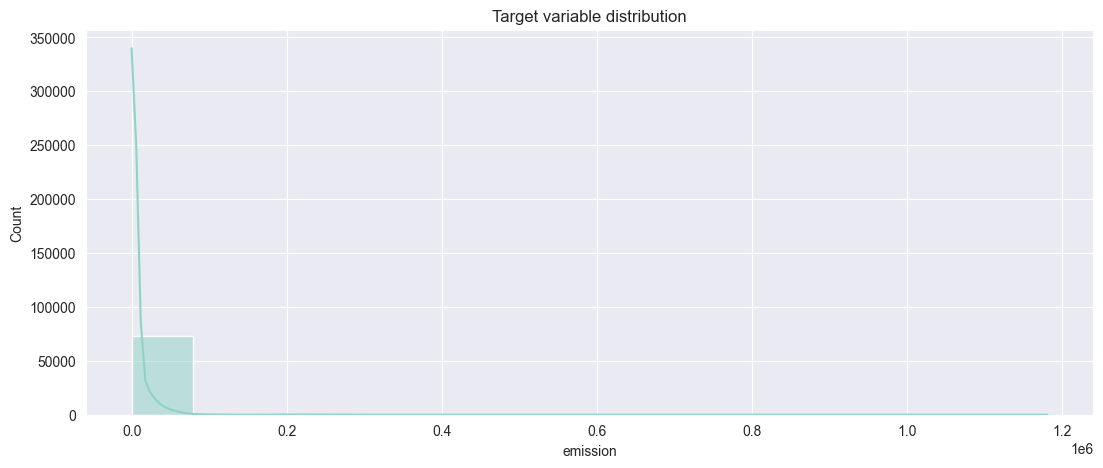

None

17.038027449698163

In [11]:
# Target variable distribution
plt.figure(figsize = (13, 5))
sns.histplot(train['emission'], kde = True, bins = 15)
plt.title('Target variable distribution')
display(plt.show(), train['emission'].skew())

## 4. Outliers

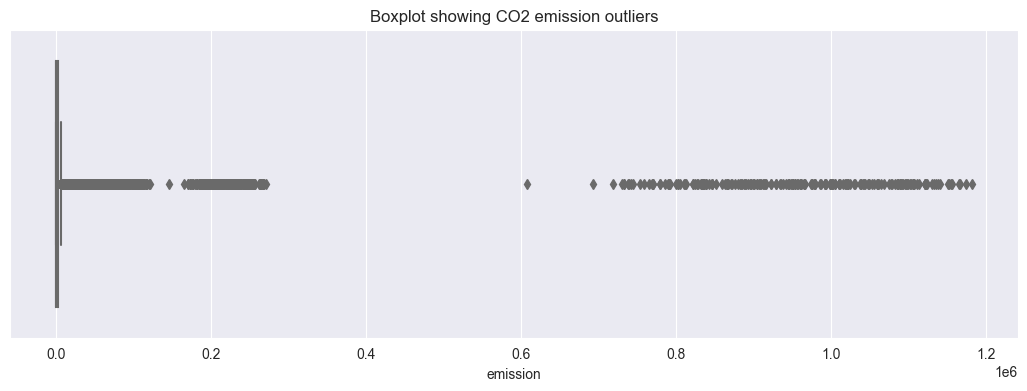

In [12]:
# Plotting boxplot for the CO2 emissions
plt.figure(figsize=(13, 4))
sns.boxplot(x=train['emission'])
plt.title('Boxplot showing CO2 emission outliers')
plt.show()

## 5. Geo Visualisation - EDA

In [13]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset=['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset=['latitude', 'longitude'])
train_coords['set_type'] = 'train'
test_coords['set_type'] = 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index=True)
# Create point geometries

geometry = gpd.points_from_xy(all_data['longitude'], all_data['latitude'])
geo_df = gpd.GeoDataFrame(
    all_data[['latitude', 'longitude', 'set_type']], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

C:\Users\Juste KOUASSI\AppData\Local\Temp\ipykernel_16136\1108718068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords['set_type'] = 'train'
C:\Users\Juste KOUASSI\AppData\Local\Temp\ipykernel_16136\1108718068.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_coords['set_type'] = 'test'


,latitude,longitude,set_type,geometry
0,-23.73,28.77,train,POINT (28.77000 -23.73000)
1,-23.73,28.77,train,POINT (28.77000 -23.73000)
2,-23.73,28.87,train,POINT (28.87000 -23.73000)
3,-23.73,28.87,train,POINT (28.87000 -23.73000)
4,-23.73,28.97,train,POINT (28.97000 -23.73000)


In [14]:
# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == 'train':
        type_color = 'green'
    elif geo_df.set_type[i] == 'test':
        type_color = 'orange'

    # Place the markers
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius=1,
            weight=4,
            zoom=10,
            popup='Set: ' + str(geo_df.set_type[i]) + '<br>'
            'Coordinates: ' + str([round(x, 2) for x in geo_df_list[i]]),
            color=type_color),
    )
    i += 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map


## 6. Missing values and duplicates

In [15]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

Bien, aucun doublon !

In [16]:
missing_rate = (train.isna().sum() * 100 / train.shape[0]).sort_values()
missing_rate

ID_LAT_LON_YEAR_WEEK                           0.000000
week_no                                        0.000000
year                                           0.000000
emission                                       0.000000
latitude                                       0.000000
                                                ...    
UvAerosolLayerHeight_sensor_azimuth_angle     93.273427
UvAerosolLayerHeight_aerosol_optical_depth    93.273427
UvAerosolLayerHeight_aerosol_pressure         93.273427
UvAerosolLayerHeight_aerosol_height           93.273427
UvAerosolLayerHeight_sensor_zenith_angle      93.273427
Length: 76, dtype: float64

In [17]:
missing_test = (test.isna().sum() * 100 / test.shape[0]).sort_values()
missing_test

ID_LAT_LON_YEAR_WEEK                           0.000000
UvAerosolIndex_solar_azimuth_angle             0.000000
UvAerosolIndex_sensor_zenith_angle             0.000000
UvAerosolIndex_sensor_azimuth_angle            0.000000
UvAerosolIndex_sensor_altitude                 0.000000
                                                ...    
UvAerosolLayerHeight_sensor_zenith_angle      93.484066
UvAerosolLayerHeight_aerosol_optical_depth    93.484066
UvAerosolLayerHeight_aerosol_pressure         93.484066
UvAerosolLayerHeight_aerosol_height           93.484066
UvAerosolLayerHeight_solar_zenith_angle       93.484066
Length: 75, dtype: float64

In [18]:
# suppression de toutes les colonnes avec plus de 90% de valeurs manquantes
train_full = train[train.columns[train.isna().sum() / train.shape[0] < 0.9]]
train_full = train_full.dropna(axis=0)
train_full.shape

(68699, 69)

In [19]:
# suppression de toutes les colonnes avec plus de 90% de valeurs manquantes
test_full = test[test.columns[test.isna().sum() / test.shape[0] < 0.9]]
# test_full = test_full.dropna(axis=0)
test_full.shape

(28085, 68)

In [20]:
train_full.isna().any().sum()

0

In [21]:
test_full.isna().any().sum()

48

In [22]:
# Train to train_full sets ratio
(train_full.shape[0]) / (train.shape[0]) * 100

92.83021417471792

In [23]:
# Test to test_full sets ratio
(test_full.shape[0]) / (test.shape[0]) * 100

100.0

## 7. Date features EDA

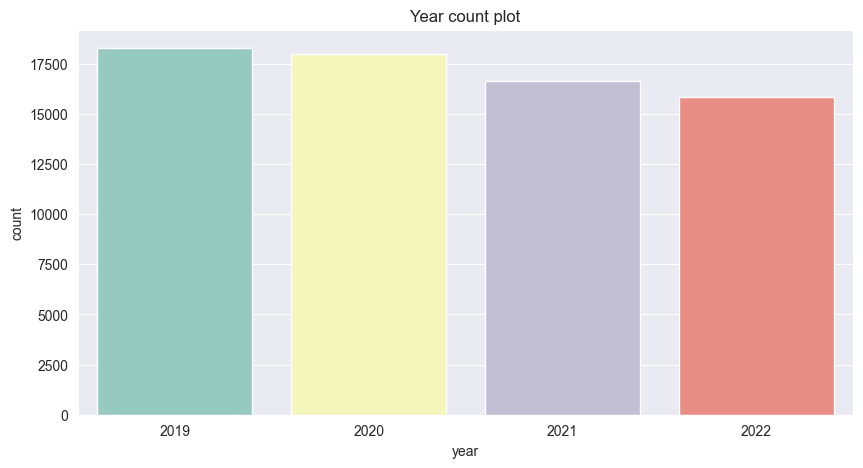

In [24]:
# Year countplot
plt.figure(figsize = (10, 5))
sns.countplot(x = 'year', data = train_full)
plt.title('Year count plot')
plt.show()

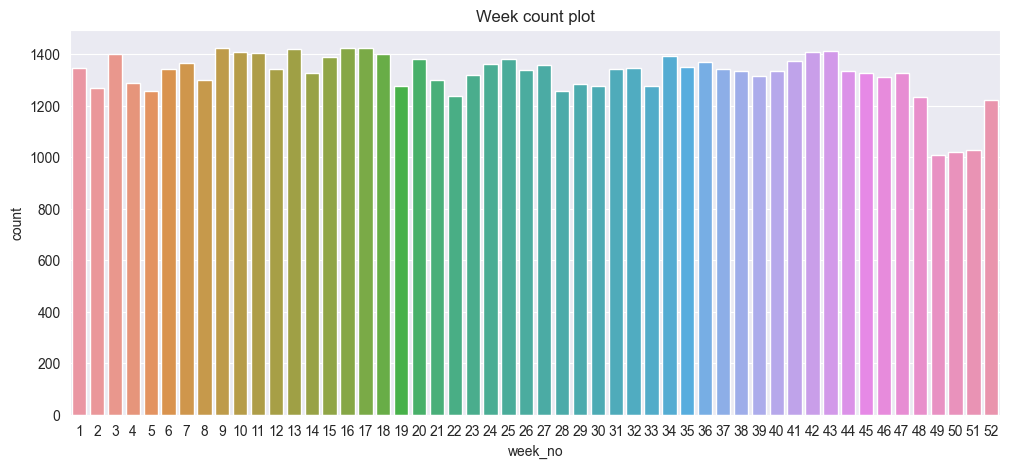

In [25]:
# Week countplot
plt.figure(figsize = (12, 5))
sns.countplot(x = 'week_no', data = train_full)
plt.title('Week count plot')
plt.show()

In [26]:
train_full.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019,52
2020,52
2021,52
2022,49


## 8. Correlations - EDA

In [ ]:
# Quantify correlations between features
top20_corrs = abs(train_full.corr()['emission']).sort_values(ascending = False).head(20)

corr = train_full[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True)
plt.title('Correlogram')
plt.show()

## 9. Timeseries visualization - EDA

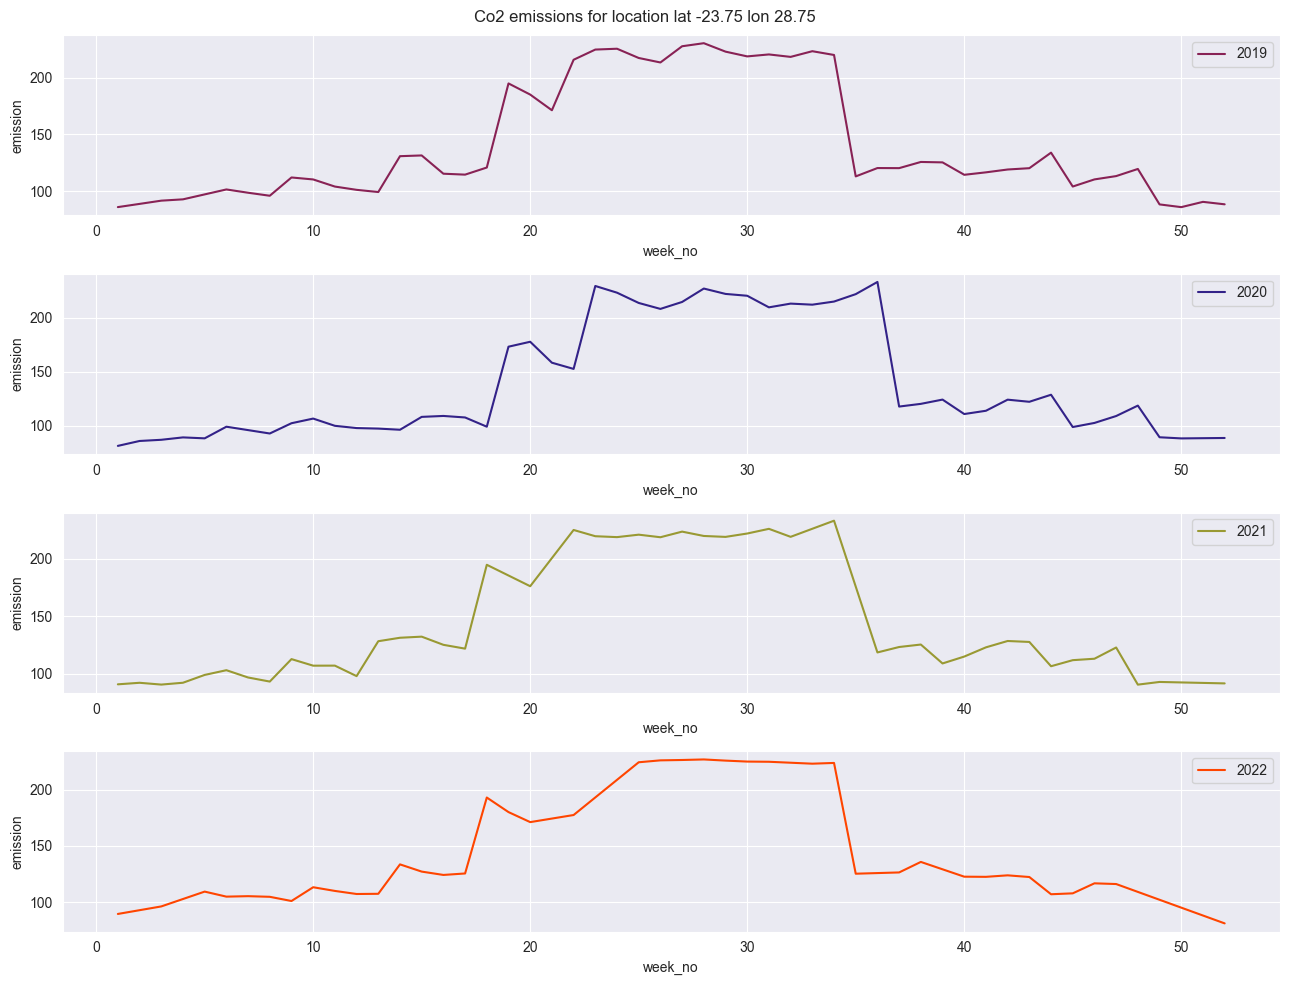

In [28]:
# Sample a unique location and visualize its emissions across the years
train_full['latitude'] = round(train_full['latitude'], 2)
train_full['longitude'] = round(train_full['longitude'], 2)
sample_loc = train_full[(train_full['latitude'] == -23.73) &
                   (train_full['longitude'] == 28.77)]

# Plot a line plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(13, 10))
fig.suptitle('Co2 emissions for location lat -23.75 lon 28.75')

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc['year'].unique(), ['#882255', '#332288', '#999933', 'orangered']):
    df = sample_loc[sample_loc['year'] == year]
    sns.lineplot(data=train_full, x=df['week_no'],
                 y=df['emission'], ax=ax, label=year, color=color)
plt.legend()
plt.tight_layout()


## 10. Feature engineering

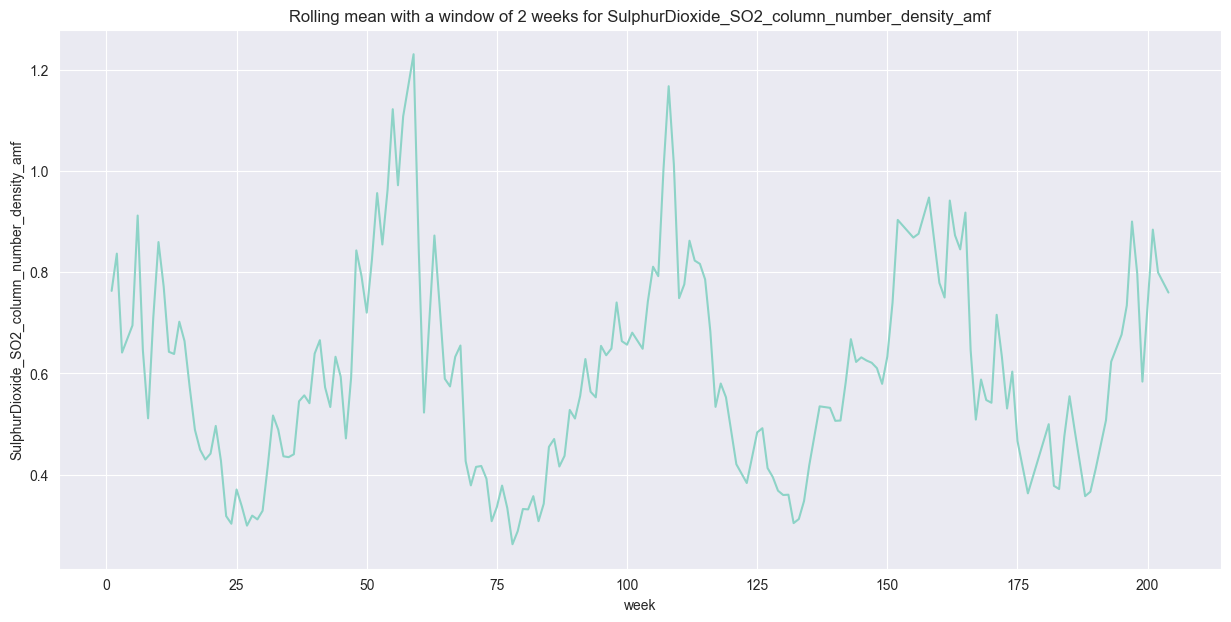

In [29]:
# Lets explore the rolling mean
# First we create a unique location from lat lon
train_full['location'] = [str(x) + '_' + str(y) for x, y in zip(train_full['latitude'], train_full['longitude'])]

# Filter based on one location
example_loc = train_full[train_full['location'] == '-23.73_28.77']

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualise rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf')
plt.xlabel('week')
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf')
plt.show()

 - There is a cyclic pattern from the above graph, which clearly shows that there is a pattern - This will be helpful to our model
 - With more research and domain knowledge generate useful features that can improve your model performance

 Other examples of feature engineering:
  - Creating cluster regions
  - Interactions between different pollutatnts - ratios, additions,subtractions...
  - Time series features

In [30]:
# Generate the above feature - rolling mean for all locations for both the train and test

# Feature engineering train
train_roll_mean = train_full.sort_values(by=['location', 'year', 'week_no']).groupby(
    ['location'])[train_full.columns[5:].tolist()].rolling(window=2).mean().reset_index()
train_roll_mean.drop(['level_1', 'emission', 'location'], axis=1, inplace=True)
train_roll_mean.columns = [
    col + '_roll_mean' for col in train_roll_mean.columns]

# Feature engineering test
test_full['latitude'], test_full['longitude'] = round(
    test_full['latitude'], 2), round(test_full['longitude'], 2)
test_full['location'] = [str(x) + '_' + str(y)
                    for x, y in zip(test_full['latitude'], test_full['longitude'])]
test_roll_mean = test_full.sort_values(by=['location', 'year', 'week_no']).groupby(
    ['location'])[test_full.columns[5:].tolist()].rolling(window=2).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis=1, inplace=True)
test_roll_mean.columns = [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()


C:\Users\Juste KOUASSI\AppData\Local\Temp\ipykernel_16136\3532606319.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_full['latitude'], test_full['longitude'] = round(
C:\Users\Juste KOUASSI\AppData\Local\Temp\ipykernel_16136\3532606319.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_full['location'] = [str(x) + '_' + str(y)


,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000129,0.438820,0.000048,0.094695,-49.026000,55.935104,-92.364110,26.771698,0.000020,0.025489,...,79559.852761,1581.442797,85797.362245,1244.571120,7.992071,0.259796,17.630362,45.737880,-89.109364,18.387366
2,0.000120,0.568128,0.000053,0.094655,-0.520018,44.992116,-88.070204,21.958601,0.000022,0.025030,...,81572.572154,1282.791996,87845.400932,966.944666,6.034695,0.248807,71.207042,49.737372,-84.134505,14.844741
3,0.000271,0.573770,0.000107,0.122802,-2.874843,47.106180,-82.843573,22.253363,0.000044,0.023687,...,70029.205187,2759.192458,76436.591607,2217.600819,6.526499,0.270112,32.449978,51.013410,-80.515631,19.533481
4,0.000338,0.608749,0.000156,0.146268,-8.862492,49.323300,-77.793343,22.962163,0.000066,0.022966,...,69815.083489,2791.479253,75984.387202,2275.478810,9.021939,0.281553,-12.158872,55.848501,-77.192182,22.996102


In [31]:
# Merge engineered features with train and test set

# Train
train_eng = train_full.sort_values(by=['location', 'year', 'week_no'], ignore_index=True).merge(
    train_roll_mean, how='left', left_index=True, right_index=True)

# Test
test_eng = test_full.sort_values(by=['location', 'year', 'week_no'], ignore_index=True).merge(
    test_roll_mean, how='left', left_index=True, right_index=True)

# Preview engineered test set
test_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,ID_-23.53_27.47_2019_1,-23.53,27.47,2019,1,0.000077,0.454468,0.000034,0.114291,-80.286309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_-23.53_27.47_2019_2,-23.53,27.47,2019,2,0.000181,0.423171,0.000062,0.075100,-17.765690,...,79559.852761,1581.442797,85797.362245,1244.571120,7.992071,0.259796,17.630362,45.737880,-89.109364,18.387366
2,ID_-23.53_27.47_2019_3,-23.53,27.47,2019,3,0.000059,0.713085,0.000043,0.114210,16.725653,...,81572.572154,1282.791996,87845.400932,966.944666,6.034695,0.248807,71.207042,49.737372,-84.134505,14.844741
3,ID_-23.53_27.47_2019_4,-23.53,27.47,2019,4,0.000483,0.434454,0.000171,0.131394,-22.475340,...,70029.205187,2759.192458,76436.591607,2217.600819,6.526499,0.270112,32.449978,51.013410,-80.515631,19.533481
4,ID_-23.53_27.47_2019_5,-23.53,27.47,2019,5,0.000193,0.783044,0.000141,0.161142,4.750356,...,69815.083489,2791.479253,75984.387202,2275.478810,9.021939,0.281553,-12.158872,55.848501,-77.192182,22.996102


<a name="Modelling"></a>
## 11.  Modelling

In [32]:
# Instantiating the models
XGB = XGBRegressor(random_state = SEED, n_jobs=-1)
LGBM = LGBMRegressor(random_state = SEED, n_jobs=-1)

In [33]:
# Instantiating the scalers
MMS = MinMaxScaler()
MAS = MaxAbsScaler()
SS = StandardScaler()
RS = RobustScaler()

In [34]:
def preprocessing_data(data: pd.DataFrame, scaler) -> pd.DataFrame:
    ''' Réalise la phase de pré-traitement d'un dataset à savoir l'encodage 
    des variables discrètes et la normalisation de toutes les variables 
    '''
    # copie du dataset
    data1 = data.copy()
    # la liste des colonnes discrètes
    object_columns = list(data1.select_dtypes(include='object').columns)
    # encodage des variables discrètes
    encoder = OrdinalEncoder()
    data1[object_columns] = encoder.fit_transform(data1[object_columns])
    # normalisation
    data1[data1.columns] = scaler.fit_transform(data1)
    return data1

In [35]:
scaler = RS
train_eng_pp = preprocessing_data(train_eng, scaler)
test_eng_pp = preprocessing_data(test_eng, scaler)
# Selecting the independent variables and the target variable
X = train_eng_pp.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1)
y = train_eng_pp['emission']
# spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

In [36]:
def model_prediction(model):
	''' détermine la prediction d'un modèle
	'''
	model.fit(X_train, y_train)
	y_pred = model.predict(X_test)
	print(f'RMSE Score : {mean_squared_error(y_test, y_pred, squared=False)}')
	return y_pred

Test du modèle sur le train set

In [37]:
from sklearn.tree import DecisionTreeRegressor

def model_prediction_kn(model):
	''' détermine la prediction d'un modèle
	'''
	model.fit(X_train.fillna(0), y_train.fillna(0))
	y_pred = model.predict(X_test.fillna(0))
	print(f'RMSE Score : {mean_squared_error(y_test, y_pred, squared=False)}')
	return y_pred

In [38]:
DTR = DecisionTreeRegressor()
peur = model_prediction_kn(DTR)

RMSE Score : 5.279274496560529


In [39]:
model = LGBM
y_pred = model_prediction(model)
# SS 0.29
# RS 5.43 -> meilleur score public
# RS 3.96
# MAS 0.0122

RMSE Score : 5.4372932586418505


### Amélioration avec GridSearchCV

In [40]:
# params_grid: dict[str, tuple] = {
#     'random_state': (0, 22, 42, 2023),
#     'n_estimators': (10, 20, 30),
#     'max_depth': (3, 5, 8),
#     'min_samples_leaf': (4, 6, 8),
#     'learning_rate': (0.1, 0.01)
# }
# grid_cv = GridSearchCV(model, params_grid, n_jobs=-1, verbose=2, cv=3)
# grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=6. Current value: min_data_in_leaf=6
[LightGBM] [Warning] Unknown parameter: min_samples_split


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=22), n_jobs=-1,
             param_grid={'learning_rate': (0.1, 0.01), 'max_depth': (3, 5, 8),
                         'min_samples_leaf': (4, 6, 8),
                         'min_samples_split': (4, 8),
                         'n_estimators': (10, 20, 30),
                         'random_state': (0, 22, 42, 2023)},
             verbose=2)

In [41]:
grid_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_samples_leaf': 6,
 'min_samples_split': 4,
 'n_estimators': 30,
 'random_state': 0}

In [49]:
optimized_lgbm = LGBMRegressor(
    learning_rate=grid_cv.best_params_['learning_rate'],
    max_depth=grid_cv.best_params_['max_depth'],
    min_samples_leaf=grid_cv.best_params_['min_samples_leaf'],
    n_estimators=grid_cv.best_params_['n_estimators'],
    random_state=grid_cv.best_params_['random_state']
)

y_pred = model_prediction(optimized_lgbm)
model = optimized_lgbm

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=6. Current value: min_data_in_leaf=6
RMSE Score : 4.330208312632336


In [53]:
optimized_dtr = DecisionTreeRegressor(
    max_depth=grid_cv.best_params_['max_depth'],
    min_samples_leaf=grid_cv.best_params_['min_samples_leaf'],
    random_state=grid_cv.best_params_['random_state']
)

peur = model_prediction_kn(optimized_dtr)

RMSE Score : 4.7731720048142865


Analyse des prédictions

In [43]:
pred_errors = X_test.copy()
pred_errors['emission'] = y_test
pred_errors['prediction'] = y_pred
pred_errors['error'] = abs(pred_errors['prediction'] - pred_errors['emission'])
pred_errors = pred_errors[['latitude', 'longitude', 'year',	'week_no', 'emission', 'prediction', 'error']]
pred_errors.sort_values(by = 'error', ascending = False, inplace = True)
pred_errors

,latitude,longitude,year,week_no,emission,prediction,error
18810,0.564103,0.193548,-0.5,-0.692308,343.769148,145.147872,198.621276
18853,0.564103,0.193548,-0.5,0.961538,387.528874,212.130666,175.398209
18927,0.564103,0.193548,0.5,0.307692,383.910651,217.776801,166.133849
18854,0.564103,0.193548,-0.5,1.000000,352.750989,186.620885,166.130104
18899,0.564103,0.193548,0.0,0.884615,356.765458,192.461388,164.304070
...,...,...,...,...,...,...,...
50116,-0.384615,0.548387,-0.5,-0.076923,1.478716,1.478987,0.000271
13047,0.974359,0.290323,-0.5,-0.730769,0.340403,0.340248,0.000155
58866,-0.871795,-0.032258,-0.5,0.846154,0.363015,0.362865,0.000150
33287,0.025641,-0.612903,0.0,0.692308,0.666824,0.666679,0.000145


In [48]:
pred_errors.error.sum()

26658.554784651456

Niveaux d'importance des features pris en compte par le modèle

In [61]:
model.feature_importances_[model.feature_importances_ > 0].size

71

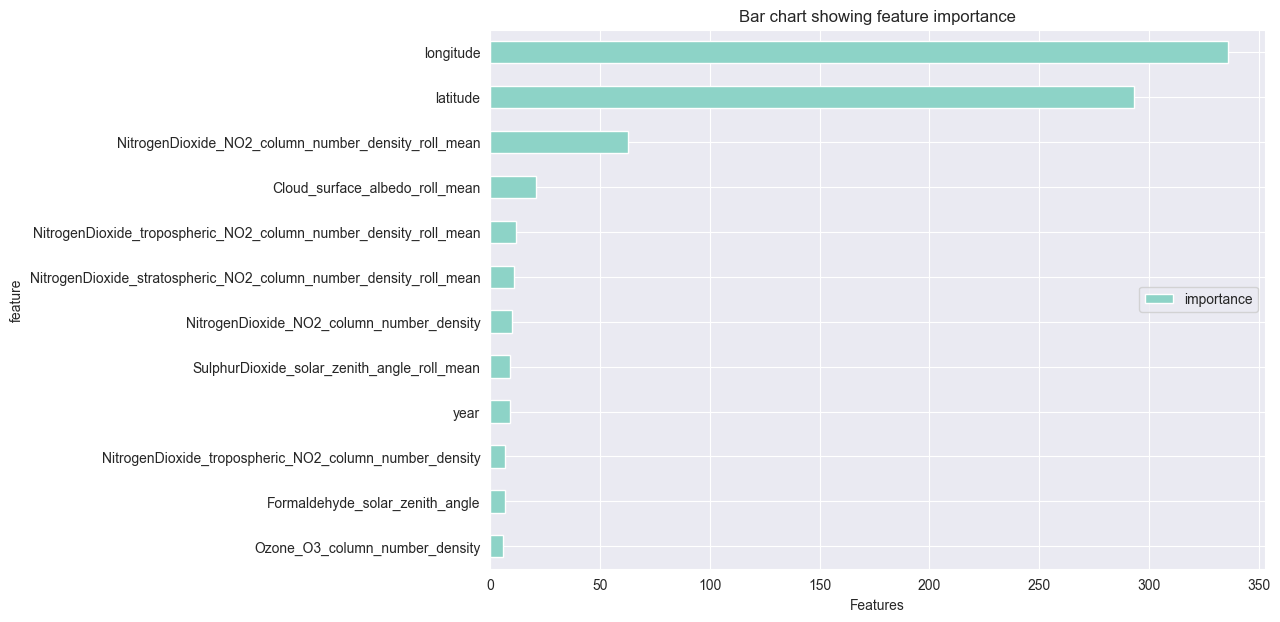

In [62]:
impo_df = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).set_index(
    'feature').sort_values(by='importance', ascending=False)
impo_df_12 = impo_df[:12].sort_values(by='importance', ascending=True)
impo_df_12.plot(kind='barh', figsize=(10, 7))
plt.legend(loc='center right')
plt.title('Bar chart showing feature importance')
plt.xlabel('Features')
plt.show()


In [93]:
len(impo_df[impo_df.importance > 4].index.to_list())

15

In [92]:
train_selected = train_eng_pp[impo_df[impo_df.importance > 4].index.to_list()]

test_selected = test_eng_pp[impo_df[impo_df.importance > 4].index.to_list()]

display(train_selected.head(), test_selected.head())

,longitude,latitude,NitrogenDioxide_NO2_column_number_density_roll_mean,Cloud_surface_albedo_roll_mean,NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_stratospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_NO2_column_number_density,year,SulphurDioxide_solar_zenith_angle_roll_mean,Formaldehyde_solar_zenith_angle,NitrogenDioxide_tropospheric_NO2_column_number_density,Ozone_O3_column_number_density,UvAerosolIndex_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,Cloud_solar_zenith_angle_roll_mean
0,0.0,1.128205,NaN,NaN,NaN,NaN,-0.486591,-0.5,NaN,-0.981244,-0.297452,0.052946,-0.911113,0.011776,NaN
1,0.0,1.128205,-0.223224,0.915330,-0.002900,-0.304203,0.095707,-0.5,-0.934341,-0.914418,0.316264,-0.262030,-0.937943,1.176849,-0.956934
2,0.0,1.128205,-0.226975,0.263537,0.053371,-0.431458,-0.493812,-0.5,-0.804389,-0.726159,-0.187956,-0.233186,-0.963536,0.023867,-0.969992
3,0.0,1.128205,-0.451080,0.059123,-0.145614,-0.488644,-0.335726,-0.5,-0.750611,-0.778322,-0.070934,-0.534067,-1.083600,0.002076,-1.225553
4,0.0,1.128205,-0.618645,0.494873,-0.272108,-0.394790,-0.816399,-0.5,-0.689029,-0.708022,-0.434096,-0.433132,-1.085626,-3.467492,-1.079339


,longitude,latitude,NitrogenDioxide_NO2_column_number_density_roll_mean,Cloud_surface_albedo_roll_mean,NitrogenDioxide_tropospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_stratospheric_NO2_column_number_density_roll_mean,NitrogenDioxide_NO2_column_number_density,year,SulphurDioxide_solar_zenith_angle_roll_mean,Formaldehyde_solar_zenith_angle,NitrogenDioxide_tropospheric_NO2_column_number_density,Ozone_O3_column_number_density,UvAerosolIndex_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,Cloud_solar_zenith_angle_roll_mean
0,-0.958333,1.02439,NaN,NaN,NaN,NaN,-0.233593,-0.5,NaN,-0.439051,-0.156665,0.077818,-0.986281,-0.974197,NaN
1,-0.958333,1.02439,-0.187907,0.573446,-0.101370,-0.225035,0.059624,-0.5,-0.603106,-0.732255,0.165729,-0.224862,-1.025270,2.837957,-0.998572
2,-0.958333,1.02439,-0.022062,0.429500,0.060502,-0.215129,0.100911,-0.5,-0.824076,-0.785283,0.177377,-0.266075,-1.048632,0.013765,-1.166617
3,-0.958333,1.02439,0.167618,0.708557,0.225638,-0.167135,0.442199,-0.5,-0.810544,-0.726826,0.506506,-0.228263,-1.102812,-3.168459,-0.944205
4,-0.958333,1.02439,0.263896,0.858425,1.095218,-0.301802,0.295100,-0.5,-0.778002,-0.801091,1.971856,-0.008646,-0.971078,0.026251,-0.779955


Réentraînement après le feature engineering

In [94]:
X_selected = train_selected
y_selected = train_eng_pp['emission']
# spliting
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size = 0.3, random_state = SEED)

In [95]:
LGBM.fit(X_train_selected, y_train_selected)
y_pred = LGBM.predict(X_test_selected)
print(f'RMSE Score : {mean_squared_error(y_test_selected, y_pred, squared=False)}')

RMSE Score : 3.752983307877661


In [96]:
model_selected = LGBM

## 12. Making predictions of the test set and creating a submission file

In [97]:
# Make prediction on the test set
# test_df = test_eng_pp.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1).fillna(0)
# predictions = model.predict(test_df)

test_df = test_selected
predictions = model_selected.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_eng['ID_LAT_LON_YEAR_WEEK'], 'emission': predictions})
sub_file.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,-1.877223
1,ID_-23.53_27.47_2019_2,-0.004416
2,ID_-23.53_27.47_2019_3,0.004201
3,ID_-23.53_27.47_2019_4,-0.044803
4,ID_-23.53_27.47_2019_5,0.187517


In [91]:
# Create file
sub_file.to_csv(
    f'soumissions/submission_{dt.now().strftime(format="%Y-%m-%d_%Hh%M")}.csv', index=False)